In [55]:

import os
from PIL import Image
import numpy as np
import torch
import wfdb
from torch.utils.data import DataLoader
from dataset import ECGDataset
from torchvision.utils import make_grid, save_image
from resnet import resnet34
from utils import cal_scores, find_optimal_threshold, split_data
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = 'cpu'

In [56]:
model_path = "models/resnet34_combined_12_42_30.pth"

In [57]:
label_csv = os.path.join("data/CPSC", 'labels.csv')
nleads = 12
net = resnet34(input_channels=nleads).to(device)
net.load_state_dict(torch.load(model_path, map_location=device))
net.eval()

seed = 42
batch_size = 1
num_workers = 4
data_dir = 'data/CPSC'
leads = 'all'

# train_folds, val_folds, test_folds = split_data(seed=seed)
# train_dataset = ECGDataset('train', data_dir, label_csv, train_folds, leads)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
# val_dataset = ECGDataset('val', data_dir, label_csv, val_folds, leads)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
# test_dataset = ECGDataset('test', data_dir, label_csv, test_folds, leads)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [58]:
# (data , label) = next(iter(test_loader))
ecg_data  , _ = wfdb.rdsamp("data/CPSC/A0010")
nsteps, _ = ecg_data.shape
print(ecg_data.shape)
ecg_data = ecg_data[-15000:, :]
result = np.zeros((15000, 12)) # 30 s, 500 Hz
result[-nsteps:, :] = ecg_data
data = torch.from_numpy(result.transpose()).float()
print(data.shape)
# test_loader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
# (d) = next(iter(test_loader))
data = data.reshape((1,12,15000))

data_device = data.to(device)
output = net(data_device)

(5000, 12)
torch.Size([12, 15000])


In [59]:
output

tensor([[ -9.8208, -10.3855, -10.7100,  -5.9196,   7.2488,  -7.5288, -11.2328,
          -4.1076, -10.1691]], device='mps:0', grad_fn=<LinearBackward0>)

In [60]:
output[:,5].backward()
gradients = net.get_activations_gradient()

In [61]:
gradients.shape

torch.Size([1, 512, 469])

In [84]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients , axis = [0,1])
print(pooled_gradients.shape)
# get the activations of the last convolutional layer
activations = net.get_activations(data_device)[0]
# print(activations)
# print(pooled_gradients)
# weight the channels by corresponding gradients
activations = activations @ pooled_gradients.reshape(-1,1)

torch.Size([469])


In [85]:
print(activations.shape)

torch.Size([512, 1])


In [86]:
activations = activations.reshape(-1)

In [87]:
activations.shape

torch.Size([512])

In [88]:
activations = (activations - activations.min()) /(activations.max() - activations.min())

In [89]:
heatmap = activations.cpu().detach().numpy()
heatmap = heatmap.reshape(-1,1)

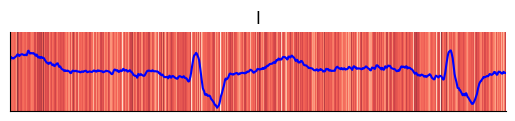

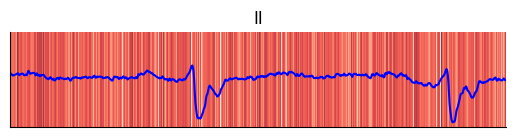

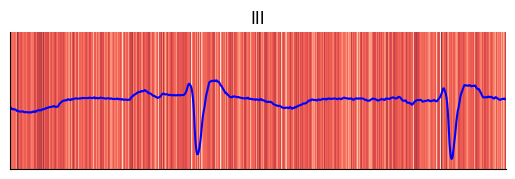

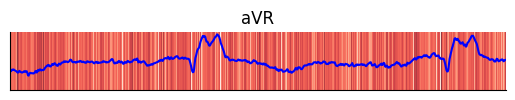

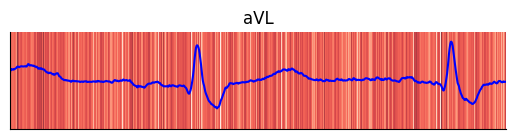

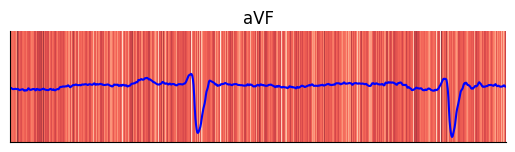

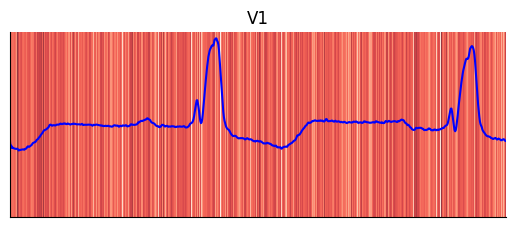

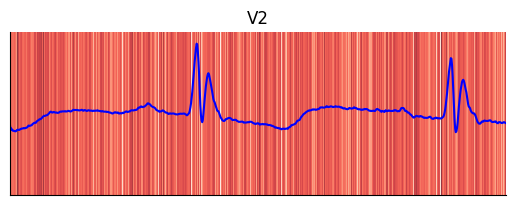

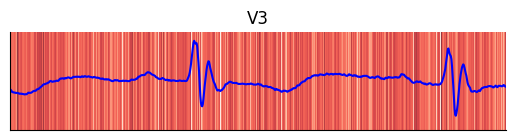

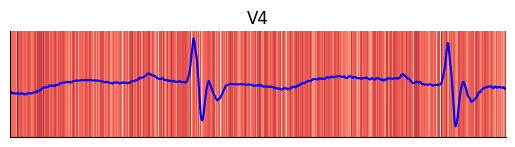

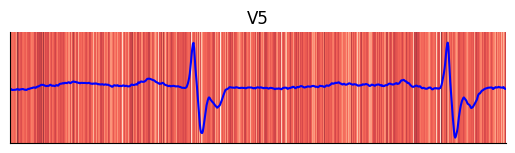

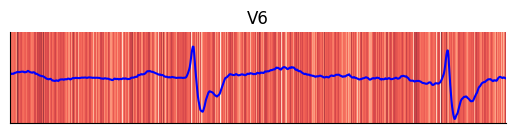

: 

In [100]:
lead_list = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
data , _ = wfdb.rdsamp("data/CPSC/A0010")
print(data.shape)
for i in range(12):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        # ax.set_ylim([-1.5, 1.5])
        ax.set_xlim([0, 800])
        ax.set_title(lead_list[i])
        ax.plot(data[:, i], color='b')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([i for i in range()])
        ax.set_yticks([])
        yabs_max = abs(max(ax.get_ylim(), key=abs))
        ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.imshow(heatmap.T, extent=[*xlim, *ylim], cmap='Reds', alpha=0.8, aspect=100)
        plt.grid(False)
        plt.show()